<a href="https://colab.research.google.com/github/ksergiou/Image_classification_tensorflow/blob/main/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Image Classification with: \\
    I. Defining and training a CNN \\
    II. Transfer Learning: use a MobileNet V2 trained on ImageNet, from TensorFlow Hub (accuracy 98.6%).

# Import Packages

In [2]:
import sys
import sklearn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers


# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

tf.__version__

'2.8.0'

# Data 


## Data Loading

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

zip_dir = tf.keras.utils.get_file(fname='cats_and_dogs_filterted.zip', 
                                  origin=_URL, 
                                  extract=True
                                  )

68616192/68606236 [==============================] - 1s 0us/step


In [4]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')

## Understading the data

In [5]:
total_tr_cl = len(os.listdir(train_dir))
total_val_cl= len(os.listdir(val_dir))

print("Number of classes (tr):", total_tr_cl)
print("Number of classes (val) :", total_val_cl)

Number of classes (tr): 2
Number of classes (val) : 2


In [6]:
BATCH_SIZE = 128  # Number of training examples to process before updating our models variables
IMG_SHAPE  = 150  # Our training data consists of images with width of 150 pixels and height of 150 pixels

In [7]:
train_image_generator = ImageDataGenerator(    
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      #zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')  # Generator for our training data

validation_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our validation data

In [8]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.


In [9]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=val_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                              class_mode='binary')

Found 1000 images belonging to 2 classes.


In [10]:
total_tr=2000
total_val=1000

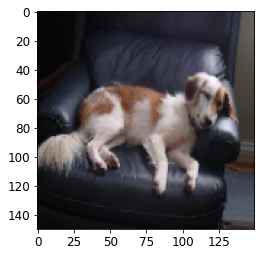

In [11]:
plt.imshow(   train_data_gen[0][0][0]   )

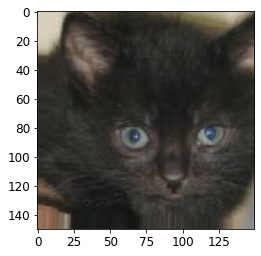

In [12]:
plt.imshow(   train_data_gen[0][0][1]   )

# I. CNN 



## Define the model

In [13]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='LeakyReLU', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='LeakyReLU',
                           #kernel_regularizer=regularizers.l2(0.0001) 
                           ),
    tf.keras.layers.Dense(2)
])

## Compile the model

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

## Train the model

In [16]:
# lr_schedule = keras.callbacks.LearningRateScheduler(     lambda epoch: 1e-1/(10*epoch+1) )

In [17]:
EPOCHS = 100
history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_tr / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
   # callbacks=[lr_schedule]
    )

Epoch 1/100
16/16 [==============================] - 29s 1s/step - loss: 0.7385 - accuracy: 0.4910 - val_loss: 0.7029 - val_accuracy: 0.5000
Epoch 2/100
16/16 [==============================] - 17s 1s/step - loss: 0.6946 - accuracy: 0.4975 - val_loss: 0.6889 - val_accuracy: 0.5000
Epoch 3/100
16/16 [==============================] - 16s 1s/step - loss: 0.6898 - accuracy: 0.5425 - val_loss: 0.6766 - val_accuracy: 0.5440
Epoch 4/100
16/16 [==============================] - 16s 1s/step - loss: 0.6823 - accuracy: 0.5515 - val_loss: 0.6708 - val_accuracy: 0.6220
Epoch 5/100
16/16 [==============================] - 17s 1s/step - loss: 0.6661 - accuracy: 0.6015 - val_loss: 0.6447 - val_accuracy: 0.5920
Epoch 6/100
16/16 [==============================] - 16s 1s/step - loss: 0.6302 - accuracy: 0.6535 - val_loss: 0.5945 - val_accuracy: 0.6830
Epoch 7/100
16/16 [==============================] - 16s 1s/step - loss: 0.5936 - accuracy: 0.6930 - val_loss: 0.5890 - val_accuracy: 0.6830
Epoch 8/100
1

## Visualize the results 

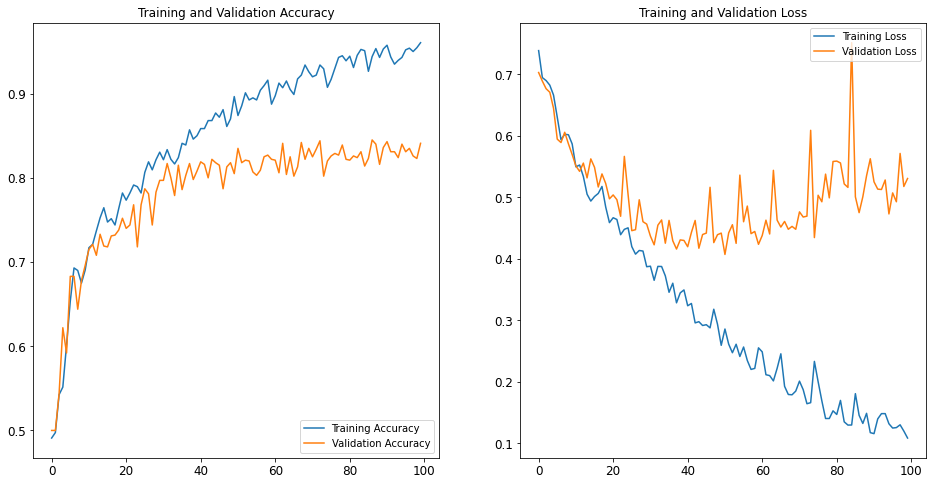

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()

At around 40 Epochs, it reached a 80% validation accuracy, which is decent. After that it overfits the training data. We reach a much better result using Transfer Learning. 

# II.Transfer Learning with Tensorflow Hub


In [19]:
# MobileNet expects 224x224 pixels images
IMAGE_RES = 224


In [20]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMAGE_RES,IMAGE_RES), #(224,224)
                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.


In [21]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=val_dir,
                                                              shuffle=False,
                                                              target_size=(IMAGE_RES,IMAGE_RES), #(224,224)
                                                              class_mode='binary')

Found 1000 images belonging to 2 classes.


## MobileNet V2 trained on ImageNet

In [22]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

In [23]:
feature_extractor.trainable = False

In [24]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense_2 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


## Fine-tune the model

In [25]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(patience=4, min_delta=1e-4) #Number of epochs with no improvement after which training will be stopped.


EPOCHS = 20
history = model.fit(train_data_gen,
                    epochs=EPOCHS,
                    validation_data=val_data_gen,
                     callbacks=[early_stopping]
                    )

Epoch 1/20
16/16 [==============================] - 32s 2s/step - loss: 0.3228 - accuracy: 0.8690 - val_loss: 0.1180 - val_accuracy: 0.9630
Epoch 2/20
16/16 [==============================] - 29s 2s/step - loss: 0.1077 - accuracy: 0.9655 - val_loss: 0.0729 - val_accuracy: 0.9760
Epoch 3/20
16/16 [==============================] - 27s 2s/step - loss: 0.0753 - accuracy: 0.9740 - val_loss: 0.0612 - val_accuracy: 0.9800
Epoch 4/20
16/16 [==============================] - 28s 2s/step - loss: 0.0628 - accuracy: 0.9785 - val_loss: 0.0546 - val_accuracy: 0.9850
Epoch 5/20
16/16 [==============================] - 27s 2s/step - loss: 0.0627 - accuracy: 0.9810 - val_loss: 0.0513 - val_accuracy: 0.9850
Epoch 6/20
16/16 [==============================] - 27s 2s/step - loss: 0.0524 - accuracy: 0.9810 - val_loss: 0.0494 - val_accuracy: 0.9820
Epoch 7/20
16/16 [==============================] - 27s 2s/step - loss: 0.0509 - accuracy: 0.9805 - val_loss: 0.0525 - val_accuracy: 0.9800
Epoch 8/20
16/16 [==

## Visualize the results

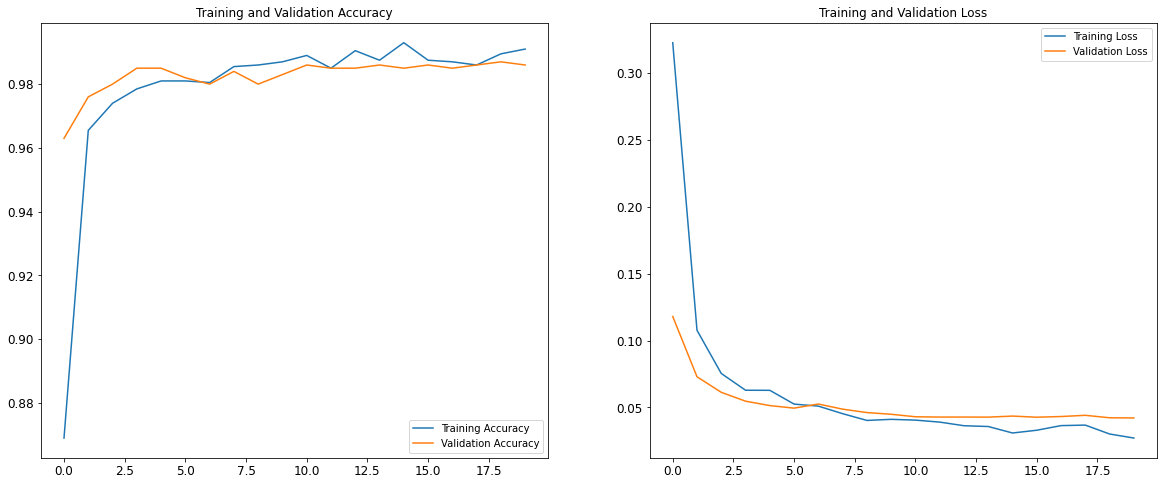

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(EPOCHS)
epochs_range=range(len(history.history['loss']))

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

What is a bit curious here is that at the beginning of training, validation performance is better than training performance.

One reason for this is that validation performance is measured at the end of the epoch, but training performance is the average values across the epoch.

The bigger reason though is that we're reusing a large part of MobileNet which is already trained on Dogs and Cats images. While doing training, the network is still performing image augmentation on the training images, but not on the validation dataset. This means the training images may be harder to classify compared to the normal images in the validation dataset.